In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [2]:
c_data = pd.read_csv('../data/data_cleaned.csv')

#### Drop Categorical feature

In the previous sections of the Data Wrangling and Exploratory Data Analysis, we observed that the feature 'Liability-Assets flag is insignificant to our analysis. Also since this is the only categorical feature remaining from the dataset, we will drop it for better performance.

In [3]:
f_data = c_data.drop('Liability-Assets_Flag', axis=1)

Now to sepearte the data-set into X and y for training Data preperation.

In [4]:
X = f_data.drop('Bankrupt?', axis=1)
y = f_data['Bankrupt?']

#### Dealing with Imbalanced Dataset

In Data Wrangling section we have obsereved that the target variable 'Bankrupt' column is highly imbalanced where minority class(Class 1) only contain 220 examples compared to 6599 (Class 0) out of total 6819 companies. This class imbalance problem pose a challenge for predictive modeling as many machine leanring algorithms used for classifications were designed around the assumption of an equal number of examples from each class. This may cause poor predictive performance in models, specificallly for the minority class.
Since the goal of this project is to predict the bankruptcy of the company (minority class of 1), the data-set should be addressed of the imbalance issue.

The approach I have used to resolve the issue is to apply SMOTE(Synthetic Minority Oversampling Technique) to the minority class. Oversampling is achieved by simply duplicating examples from the minority class in the dataset which can balance the class distribution and does not provide any additional information to the model. This technique is utilized to generate synthetic samples from minority class to imbalanced target class problem.

In [5]:
#Applying SMOTE and checking the shape of both X and y
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)
X_sm.shape, y_sm.shape

((13198, 93), (13198,))

In [6]:
#Checking the count of the classes in y data
y_sm.value_counts()

1    6599
0    6599
Name: Bankrupt?, dtype: int64

The above count confirms that we now have equal balance between Bankrupt and Survived companies

### Machine Learning with the data-set

For this notebook, I have tested following supervised learning algorithms for model prediction.
1) Logistic Regression <br>
2) Random Forest Classification <br>
3) Support Vecotr Machine

### Logistic Regression
For Logistic Regression:
- Logistic Regression(Base) - I first computed base model with default parameters and only oversampled(SMOTE) data-set
- Logistic Regression(Tuned) - I optimized the model by hyperparameter tuning

#### Logistic Regression Base model

Accuracy: 0.6138888888888889
              precision    recall  f1-score   support

           0       0.60      0.73      0.66      2005
           1       0.64      0.50      0.56      1955

    accuracy                           0.61      3960
   macro avg       0.62      0.61      0.61      3960
weighted avg       0.62      0.61      0.61      3960



<AxesSubplot:>

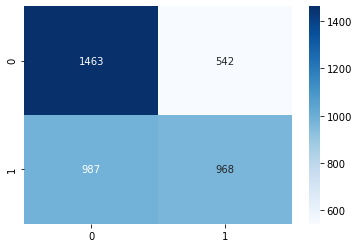

In [39]:
#Setting the estimator
logreg = LogisticRegression()
#Splliting SMOTE applied data-set
X_trainsm, X_testsm, y_trainsm, y_testsm = train_test_split(X_sm, y_sm, test_size=0.30, random_state=42)
#Fitting the Data
logreg.fit(X_trainsm, y_trainsm)
y_pred_sm = logreg.predict(X_testsm)

#Finalizing the Accuracy, Classification report and creating heat-map for visulization
print('Accuracy:', accuracy_score(y_pred_sm, y_testsm))
print(classification_report(y_testsm, y_pred_sm))
sns.heatmap(confusion_matrix(y_testsm, y_pred_sm), annot=True, cmap='Blues',fmt='d')

The Accuracy for the Logistic Regression model is 61.7%. <br>
The performance of the base model is reasonable. The percentage of the precision and recall of the classes could be improved for better accuracy.

#### Hyperparameter Tuning

In order to find the most optimal parameter for the Logistic Regression, I have used grid search with cross-validation.
For the tuning I have initiated pipeline and applied scaling to the data-set before fitting through the model.

The parameter grid is defined: 
- To find inverse of regularization strength(C) from 0.01-100.
- Regularization is specified as Ridge (L2)
- Solver option between Limited-memory-Broyden-Fletcher-Goldfarb-Shanno(lbfgs) and Library for Large Linear Classification.


In [40]:
#Initializing steps with scaling and logistic regression
steps = [('scaler',StandardScaler()),
        ('classifier', LogisticRegression())]
pipeline = Pipeline(steps)

#Defining parameter grid to be evaluated
params = {'classifier__C':[1.0,10,100,0.1,0.01],
         'classifier__penalty':['l2'],
         'classifier__solver':['lbfgs', 'liblinear']}

#Fitting in Grid search
cv = GridSearchCV(pipeline, param_grid=params, cv=3)
cv.fit(X_train, y_train)

y_pred = cv.predict(X_test)
print("Best: %f using %s" % (cv.best_score_, cv.best_params_))

Best: 0.906148 using {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


The best score defined by the search is C:1.0 with Ridge regularization and 'lbfgs' Solver option

#### Scaling the data-set

In [7]:
#Scaling X and training the data-set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sm)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_sm, test_size=0.30, random_state=42)

With the parameter described above, I have re-iterated on the Logistic Regression model to print Accuracy and Classification Report

0.9118686868686868
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      2005
           1       0.90      0.93      0.91      1955

    accuracy                           0.91      3960
   macro avg       0.91      0.91      0.91      3960
weighted avg       0.91      0.91      0.91      3960



<AxesSubplot:>

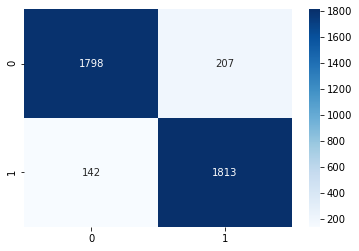

In [41]:
#Re-iterating Logistic regression with best parameter found with Grid Search
logreg_tuned=LogisticRegression(penalty='l2',C=1.0,solver='lbfgs') 
logreg_tuned.fit(X_train, y_train)
y_pred = logreg_tuned.predict(X_test)

#Finalizing the Accuracy, Classification report and creating heat-map for visulization
print(accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues',fmt='d')

We can observe few differences in Tuned Logistic Regression model:
- Accuracy has improved to 91.2% vs 61.7% in the base model
- Both Precision & Recall percentage has significantly improved
- Heat-map provide the correct prediction made for the Bankruptcy

#### Comparing ROC Curve between the models

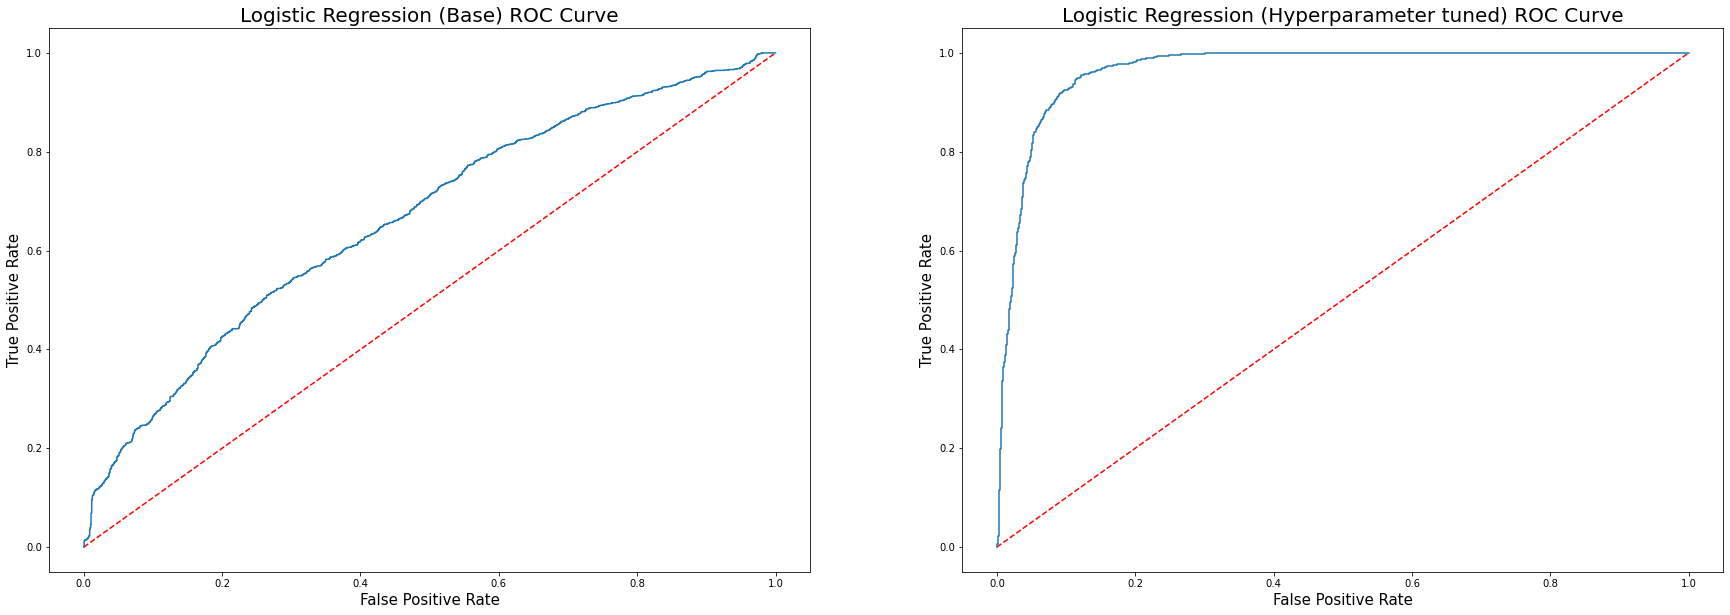

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
ax1.plot([0,1],[0,1], 'r--')
ax1.plot(fpr,tpr,label='Logistic Regression')
ax1.set_xlabel('False Positive Rate',fontsize=15)
ax1.set_ylabel('True Positive Rate',fontsize=15)
ax1.set_title('Logistic Regression (Base) ROC Curve',fontsize=20)

y_pred_logtune = logreg_tuned.predict_proba(X_test)[:,1]
hp_fpr, hp_tpr, hp_thresholds =roc_curve(y_test, y_pred_logtune)
ax2.plot([0,1],[0,1], 'r--')
ax2.plot(hp_fpr,hp_tpr,label='Logistic Regression')
ax2.set_xlabel('False Positive Rate',fontsize=15)
ax2.set_ylabel('True Positive Rate',fontsize=15)
ax2.set_title('Logistic Regression (Hyperparameter tuned) ROC Curve', fontsize=20)
plt.show();

The above ROC curve graphs of Logistic Regression (Base) vs Logistic Regression (Tuned) models provides significant improvements on True positive rate made by tuning the hyperparameters.

### Random Forest Classifier

For Random Forrest Classifier:
- Random Forest Classifier (Base) - I first computed Base Model without SMOTE and scaling on the data
- Randomized Search CV/ Grid Search CV  - I approaced 2 steps in finding the optimal parameter for the model. Since Random Forest classifier has numerous hyperparameters to evaluate, I first applied Randomized Search narrow down the optimal parameters to save from computational complexity. Then with the shortend parameters, I applied Grid Search to evalute the best parameters for the model
- Random Forest Classifier (Tuned) - Hyperparameter tuned model

#### Base Model

We will first observe the Random Forest Model without oversampling (SMOTE) and scaling of the data.

In [30]:
#Training the original X and y Data-set.
Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [19]:
rf_base = RandomForestClassifier()
rf_base.fit(Xrf_train, yrf_train)

RandomForestClassifier()

In [20]:
y_pred_RFC = rf_base.predict(Xrf_test)
print('Accuracy:',accuracy_score(y_pred_RFC, yrf_test))
print(classification_report(yrf_test, y_pred_RFC))

Accuracy: 0.9628543499511242
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1968
           1       0.57      0.10      0.17        78

    accuracy                           0.96      2046
   macro avg       0.77      0.55      0.58      2046
weighted avg       0.95      0.96      0.95      2046



The base model from original data-set show high accuracy of 96.3%. <br> 
However, on the Precision & Recall on the Bankruptcy class(which presents 57% and 10% respectively), we can observe that the performance of the model on predicting 'Survived' companies is accurate but is not reliable on predicting the 'Bankrupt' companies. Since the goal of the project is accurately predicting on the 'Bankrupt' class, the base model is not an appropriate model to use.

#### Randomized Search CV

Random Forest Classifier has numerous parameters for tuning. Although GridsearchCV function offers accurate results of simplifying the process of selecting best parameter, it will be extremely costly execution both in computing power and time to iterate all the combination of hyperparameter values.
Instead, by selecting Randomized search CV function, it allows to explicitly control the number of parameter combinations attempted by selecting best of random combination of hyperparameter values and drastically lowering the run time.<br>

The parameter grid is defined:
- Estimator: The number of trees to build between 200 to 1000
- Combination of max depth of the tree from 10 to 100
- Function to measure the quality of a split betweein Gini impurity vs Entropy
- Maximum number of feature comparison between Auto(Simply take all the features which make sense in every tree) vs Sqrt(Square root of total number of features in individual run)

In [8]:
rf = RandomForestClassifier()
#Defining array of arbitary numeric parameter and depth of each tree
estimators = [int(x) for x in np.linspace(start=200, stop=1000, num=10)]
depth = [int(x) for x in np.linspace(10, 100, num=10)]

#Setting parameters 
param = {
    'n_estimators': estimators,
    'max_depth': depth,
    'criterion': ['gini','entropy'],
    'max_features':['auto','sqrt']    
}
#Iterating Randomized Search
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param, cv=3, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=42)

In [10]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=50, n_estimators=555)

In [12]:
print("Best: %f using %s" % (rf_random.best_score_, rf_random.best_params_))

Best: 0.970123 using {'n_estimators': 555, 'max_features': 'auto', 'max_depth': 50, 'criterion': 'gini'}


The best parameter defined by the search is with estimator of 555,tree max depth of 50, Gini impurity and Auto option of maximum number of feature.

In [14]:
rfc1 = RandomForestClassifier(n_estimators=555, max_features='auto', max_depth=50, criterion='gini', random_state=42)
rfc1.fit(X_train, y_train)
y_pred_rfc1 = rfc1.predict(X_test)
print(accuracy_score(y_pred_rfc1, y_test))

0.9785353535353535


The accuracy score depicted from the best parameter searched from the random search CV is 97.9%

In [20]:
print(classification_report(y_test, y_pred_rfc1))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2005
           1       0.96      1.00      0.98      1955

    accuracy                           0.98      3960
   macro avg       0.98      0.98      0.98      3960
weighted avg       0.98      0.98      0.98      3960



#### Ranking the test scores

In [13]:
#Setting cross validation results into Dataframe and setting sorting through the rank scores
df = pd.DataFrame(rf_random.cv_results_)
df = df.set_index('rank_test_score')
df.sort_index()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,
1,30.731771,0.980944,0.435334,0.005313,555,auto,50,gini,"{'n_estimators': 555, 'max_features': 'auto', ...",0.972403,0.964274,0.973693,0.970123,0.004169
2,33.543887,1.532408,0.488334,0.033865,555,sqrt,50,gini,"{'n_estimators': 555, 'max_features': 'sqrt', ...",0.971104,0.965248,0.973693,0.970015,0.003532
3,26.455957,0.246322,0.363333,0.006945,466,sqrt,50,gini,"{'n_estimators': 466, 'max_features': 'sqrt', ...",0.971429,0.963625,0.974992,0.970015,0.004747
4,40.729141,0.314030,0.489665,0.021642,733,auto,70,gini,"{'n_estimators': 733, 'max_features': 'auto', ...",0.971104,0.964274,0.974342,0.969907,0.004197
5,30.343781,0.969560,0.392333,0.036059,466,sqrt,20,gini,"{'n_estimators': 466, 'max_features': 'sqrt', ...",0.971753,0.962325,0.974342,0.969474,0.005164
6,72.001199,1.630633,0.773375,0.107397,1000,auto,70,entropy,"{'n_estimators': 1000, 'max_features': 'auto',...",0.972403,0.962975,0.972394,0.969257,0.004442
7,52.865824,0.797367,0.554000,0.037480,733,auto,40,entropy,"{'n_estimators': 733, 'max_features': 'auto', ...",0.971429,0.962325,0.972069,0.968608,0.004450
8,13.988406,0.209135,0.173334,0.021172,200,auto,50,entropy,"{'n_estimators': 200, 'max_features': 'auto', ...",0.969156,0.962975,0.972069,0.968067,0.003792
9,12.739333,0.116853,0.134667,0.003300,200,sqrt,10,entropy,"{'n_estimators': 200, 'max_features': 'sqrt', ...",0.965909,0.956804,0.968821,0.963845,0.005118


The above table represents the rank of the each combination of the random hyperparameter values defined by the randomized search by their test scores. <br>
By observing the first 5 rankings, we can narrow down that the best scores are performed from:
- Estimators between 400 to 700
- Max tree depth between 20,50 and 70
- Gini impurity is dominant in the rankings
- Auto will be used for the max feature

#### GridSearchCV

With the narrowed down list of the hyperparameter values, we can iterate through GridSearchCV to search for better performing parameters.

In [28]:
#Setting the parameter grid with the narrowed down values
param = {
    'n_estimators': [400,500,600,700],
    'max_depth': [20,50,70],
    'criterion': ['gini'],
    'max_features':['auto']    
}
rfg = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(estimator=rfg, param_grid=param, cv=3, n_jobs=-1)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [20, 50, 70],
                         'max_features': ['auto'],
                         'n_estimators': [400, 500, 600, 700]})

In [27]:
rf_grid.best_params_

{'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'auto',
 'n_estimators': 500}

The parameter defined through Grid Search does not seems to have significant difference from parameters defined by Random Search

In [24]:
#Re-iterating the Random Forest Classifier with Grid Search defined parameters
rfc2 = RandomForestClassifier(n_estimators=500, max_features='auto', max_depth=50, criterion='gini', random_state=42)
rfc2.fit(X_train, y_train)
pred_g = rfc2.predict(X_test)

0.9782828282828283
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2005
           1       0.96      1.00      0.98      1955

    accuracy                           0.98      3960
   macro avg       0.98      0.98      0.98      3960
weighted avg       0.98      0.98      0.98      3960



<AxesSubplot:>

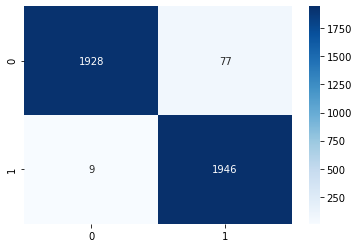

In [25]:
print(accuracy_score(pred_g, y_test))
print(classification_report(y_test, pred_g))
sns.heatmap(confusion_matrix(y_test, pred_g), annot=True, cmap='Blues',fmt='d')

The Accuracy, Precision and Recall scores are exact to the above Randomized Search defined parameters. This concludes that narrowing down the hyperparameter is unnecessary and finalized values from the first search can be applied for the Random Forest Classfication

### Support Vector Machine

I have applied similar steps from Random Forest Classification to the Support Vector Machine:

Support Vector Machine (Base) - I first computed Base Model without SMOTE and scaling on the data
Grid Search CV - I applied Grid Search to evalute the best parameters for the model
Support Vector Machine (Tuned) - Hyperparameter tuned model

#### Base Model

In [31]:
#Applying data with out oversampling and scaling
SVM_base = SVC()
SVM_base.fit(Xrf_train, yrf_train)
y_pred_svmb = SVM_base.predict(Xrf_test)

In [32]:
print(accuracy_score(y_pred_svmb, yrf_test))
print(classification_report(yrf_test, y_pred_svmb))

0.9618768328445748
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1968
           1       0.00      0.00      0.00        78

    accuracy                           0.96      2046
   macro avg       0.48      0.50      0.49      2046
weighted avg       0.93      0.96      0.94      2046



The results for the SVM base model presents very similar pattern to the Random Forest Classification. Again, the outcome of the accuracy score is very high however, we have 0% for both Precision and Recall scores. <br>
The result is worse than the previous models. This indicates that this base model could not perform a single case of bankrupt class.

#### GridSearchCV

The parameter grid is defined: 
- To find inverse of regularization strength(C) from 0.1-100.
- Gamma, 'spread' of the kernel from 0.001 to 1
- I used Radian Basis Function as kernel to specify the gamma parameter

In [33]:
param_grid = {'C': [0.1, 1, 10, 100],
             'gamma': [1, 0.1, 0.01, 0.001],
             'kernel':['rbf']}
SVC_grid = GridSearchCV(SVM_model, param_grid=param_grid, refit=True, verbose=3)
SVC_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.503, total=  12.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.503, total=  12.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.1s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.511, total=  12.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.503, total=  12.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.503, total=  12.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.915, total=   8.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.919, total=   8.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.916, total=   8.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.923, total=   8.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] .......... C=100, gamma=1, kernel=rbf, score=0.921, total=  14.8s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.909, total=  14.7s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.919, total=  14.4s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.923, total=  15.0s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.905, total=  14.4s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.986, total=   5.6s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=100, gamma=0.1, kernel=rbf, score=0.982, total=   5.4s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  9.4min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=3)

In [34]:
print("Best: %f using %s" %(SVC_grid.best_score_, SVC_grid.best_params_))

Best: 0.983871 using {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [44]:
#Re-iterating the SVM with Grid Search defined parameters
SVM_tuned = SVC(C=1.0, gamma=0.1, kernel='rbf',probability=True)
SVM_tuned.fit(X_train, y_train)
y_pred_svm = SVM_tuned.predict(X_test)

Accuracy: 0.9858585858585859
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2005
           1       0.98      0.99      0.99      1955

    accuracy                           0.99      3960
   macro avg       0.99      0.99      0.99      3960
weighted avg       0.99      0.99      0.99      3960



<AxesSubplot:>

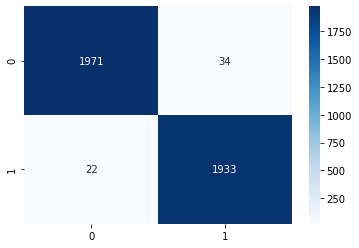

In [45]:
print('Accuracy:',accuracy_score(y_pred_svm, y_test))
print(classification_report(y_test, y_pred_svm))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, cmap='Blues',fmt='d')

We can observe that SVM model has the highest score for all of Accuracy, Precision and Recall

### ROC Curve

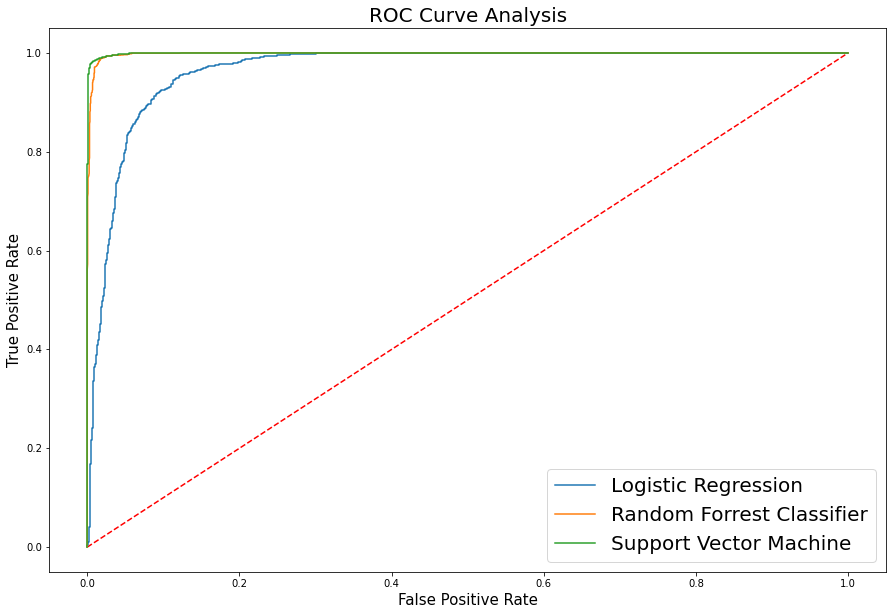

In [47]:
fig = plt.figure(figsize=(15,10))
y_pred_logtune = logreg_tuned.predict_proba(X_test)[:,1]
hp_fpr, hp_tpr, hp_thresholds =roc_curve(y_test, y_pred_logtune)
y_pred_rfcgrid = rfc2.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, rf_thresholds =roc_curve(y_test, y_pred_rfcgrid)
y_pred_svmtune = SVM_tuned.predict_proba(X_test)[:,1]
svm_fpr, svm_tpr, svm_thresholds =roc_curve(y_test, y_pred_svmtune)
plt.plot([0,1],[0,1], 'r--')
plt.plot(hp_fpr,hp_tpr,label='Logistic Regression')
plt.plot(rf_fpr,rf_tpr,label='Random Forrest Classifier')
plt.plot(svm_fpr, svm_tpr,label='Support Vector Machine')
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('ROC Curve Analysis', fontsize=20)
plt.legend(prop={'size':20}, loc='lower right')
plt.show();